# Sign language dataset handling
Data Analysis - ISAE 2018/2019 - Gauthier Le Moulec

In [16]:
import os #path handling
import numpy as np #numpy arrays operation
import matplotlib.pyplot as plt #plotting and image viewing
import matplotlib.patches as mpatches
import skimage
import math

from skimage import filters
from skimage import morphology
from skimage import segmentation

from skimage import data
from skimage.filters import threshold_otsu, sobel, sobel_h, sobel_v
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.color import label2rgb
from skimage.transform import resize

from sklearn.neighbors import KNeighborsClassifier #kNN classifier
from sklearn.model_selection import train_test_split #Data set splitting functions
from sklearn.metrics import confusion_matrix #Confusion matrix
from sklearn import tree

#inline plots for nicer viewing
%matplotlib inline 

In [17]:
#dataPath = 'X.npy' # path to folder containing the sign language data
XFile ='X.npy' # X
YFile ='Y.npy' # Y

# 1- Data import and formatting

In [18]:
# Load input data and labels
X = np.load(XFile)
Y = np.load(YFile)
print(X.shape)
print(Y.shape)

(2062, 64, 64)
(2062, 10)


Let's define a function that converts the one-hot encoded labels to the corresponding sign language value, using the ClassLabels.txt mapping file

In [19]:
def labelToSignNumber(label):
  """
  Convert a one-hot encoded label to the
  corresponding sign language value.
  Mapping is given in the ClassLabels.txt
  file.
  
  Args:
    label: (numpy.array) One-hot encoded label

  Returns: (float) Sign language value
  """
  labelValue = np.argmax(label)
  mapping = {0:9,
             1:0,
             2:7,
             3:6,
             4:1,
             5:8,
             6:4,
             7:3,
             8:2,
             9:5}
  return mapping[labelValue]

In [20]:
result = [labelToSignNumber(item) for item in Y]

Image 55 is a: 9


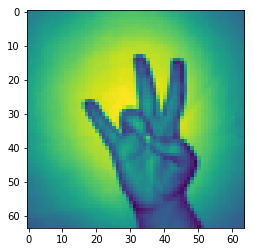

Image 600 is a: 7


In [21]:
# Let's test our function
y55 = labelToSignNumber(Y[55])
print('Image 55 is a: {}'.format(y55))
plt.imshow(X[600])
plt.show()
y600 = labelToSignNumber(Y[600])
print('Image 600 is a: {}'.format(y600))

# 2- Filtering and features construction
Let's apply some edge detectors on an example image

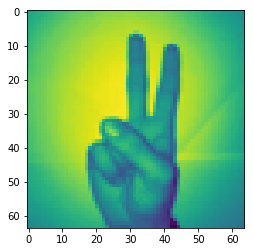

2


In [22]:
# Display an image and its label
imgIdx = 1700
image = X[imgIdx]
result = Y[imgIdx]
y = labelToSignNumber(result) 
plt.imshow(image)
plt.show()
print(format(y))

In [55]:
# function which divides the image in black and white (yellow and blue here)
def threshold(image):
    thresh = image>filters.threshold_otsu(image)
    
    # design of a mask to flatten the sides of the image
    lx, ly = image.shape
    X, Y = np.ogrid[0:lx, 0:ly]
    mask = (X - lx/2)**2 + (Y - ly/2)**2 > lx*ly/7
    thresh[mask] = 1
    return thresh

<function matplotlib.pyplot.show(*args, **kw)>

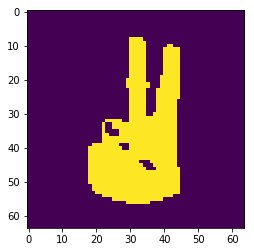

In [24]:
# effect of the threshold
thresh = threshold(image)
plt.imshow(thresh)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

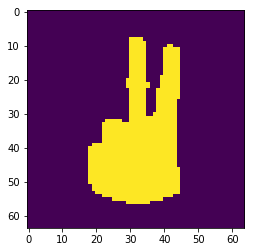

In [13]:
# effect of a filter removing little objects
lawFreqFilter = remove_small_holes(thresh)
plt.imshow(lawFreqFilter)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

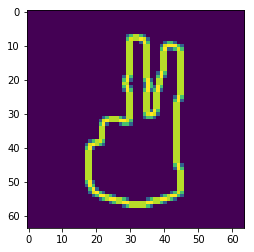

In [14]:
# effect of a filter emphasizing the sides of the hand (this filter won't be used)
sideH = sobel(lawFreqFilter)
plt.imshow(sideH)
plt.show

In [15]:
# function which centers the image on the hand
# the aim is to create a rectangle shape which contains the whole hand and barely more.
def recenter(image):
    m,n = image.shape
    
    minR = m-1
    minC = n-1
    maxR = 0
    maxC = 0
    
    for j in range(0,n-1):
        for i in range(0,m-1):
            if image[i][j] > 0.1 and j < minC:
                minC = j
                #print("On stoppe la boucle")
                break
    
    #print(minC)
    
    for i in range(0,m-1):
        for j in range(0,n-1):
            if image[i][j] > 0.1 and i < minR:
                minR = i
                #print("On stoppe la boucle")
                break
                
    #print(minR)
    
    for j in range(0,n-1):
        for i in range(0,m-1):
            if image[i][n-1-j] > 0.1 and n-1-j > maxC:
                maxC = n-1-j
                #print("On stoppe la boucle")
                break
                
    #print(maxC)
    
    for i in range(0,m-1):
        for j in range(0,n-1):
            if image[m-1-i][j] > 0.1 and m-1-i > maxR:
                maxR = m-1-i
                #print("On stoppe la boucle")
                break
                
    #print(maxR)
        
    new_image = image[minR-2:maxR+2,minC-2:maxC+2] # the marge of 2 is used to have a global vision
    return new_image


<function matplotlib.pyplot.show(*args, **kw)>

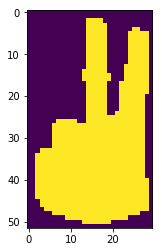

In [16]:
#effect of the center fonction
centered = recenter(lawFreqFilter)
plt.imshow(centered)
plt.show

In [17]:
# useless function (useful to compute the number of digits, with combination of nbDigits below)
def getZ(image):
    z = np.mean(image[8:20,:], axis=0)
    a,b = image.shape
    #print(b)
    for i in range(0,b):
        if z[i] > 0.3:
            z[i] = math.ceil(z[i])
        else:
            z[i] = math.trunc(z[i])
    return z

In [27]:
def nbDigits(z):
    count = 0
    nb = 0
    for i in range(1,24):
        if z[i] == 1.0 and z[i-1]==0.0:
            nb += 1
        elif z[i] == 1.0 and z[i-1] == 1.0:
            if count == 19:
                nb = 0
            else:
                count += 1
    return nb

In [42]:
# this function is not useful to understand the solving
def createData(image):
    thresh = threshold(image)
    lawFreqFilter = remove_small_holes(thresh)
    centered = recenter(lawFreqFilter)
    a,b = centered.shape
    resized = resize(centered,(a,25))
    z = getZ(resized)
    #nb = nbDigits(z)
    return z

In [55]:
def selectImagePart(image):
    newImage = image[8:20,:]
    return newImage

In [61]:
# this function gathers all the steps of filtering, and generates the finale image which will be processed
def createDataBis(image):
    thresh = threshold(image)
    lawFreqFilter = remove_small_holes(thresh)
    centered = recenter(lawFreqFilter)
    a,b = centered.shape
    
    # resizing to have a dataset of final images with the same dimensions.
    resized = resize(centered,(a,25))
    finalImage = selectImagePart(resized)
    return finalImage

C:\Users\almal\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\almal\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<function matplotlib.pyplot.show(*args, **kw)>

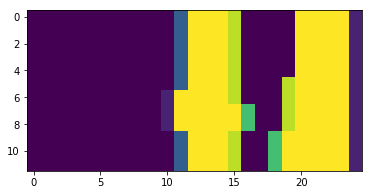

In [64]:
im = createDataBis(X[1700])
plt.imshow(im)
plt.show

# 3- Problem solving

C:\Users\almal\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\almal\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


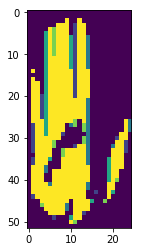

In [87]:
data = [createDataBis(item) for item in X]

In [85]:
newData = [np.array(item).flatten() for item in data]

In [79]:
trainData,testData,trainY,testY = train_test_split(newData,result,test_size=0.2)

In [80]:
kNN = KNeighborsClassifier(n_neighbors=4,algorithm='kd_tree',metric='minkowski',p=2,n_jobs=-1)
#trainData.ndim
kNN.fit(trainData,trainY)


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

In [81]:
kNN.score(testData,testY)

0.87409200968523

In [82]:
decisiontree = tree.DecisionTreeClassifier(max_depth=10)
decisiontree.fit(trainData,trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [83]:
decisiontree.score(testData,testY)

0.7457627118644068

[[43  0  3  0  0  0  1  0  0  1]
 [ 0 40  0  0  0  0  0  0  0  0]
 [ 0  0 34  2  0  0  0  0  0  0]
 [ 0  0  4 39  0  0  0  1  0  0]
 [ 1  0  0  0 33  2  5  1  0  0]
 [ 0  1  0  4  1 41  0  0  0  1]
 [ 1  0  1  1  2  0 32  0  0  0]
 [ 0  0  2  0  0  0  0 41  0  0]
 [ 0  2  2  1  1  0  2  1 27  0]
 [ 0  0  1  6  0  1  0  0  0 31]]


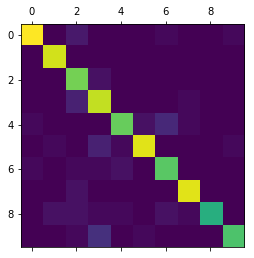

In [84]:
predictions = kNN.predict(testData)
testCM = confusion_matrix(y_pred=predictions,y_true=testY)
print(testCM)
plt.matshow(testCM);

[[ 3  5  0 21  1  4  0  0  0  0]
 [ 0 27  0  5  0  2  0  0  0  0]
 [ 0  1  0 50  0  2  0  0  0  0]
 [ 0  0  0 33  0  2  0  0  0  0]
 [ 0  2  0  4 14 25  0  0  0  0]
 [ 0  0  0  5  8 20  0  0  0  0]
 [ 0  4  0 18  1 20  0  0  0  0]
 [ 1  4  0 17  2 32  0  0  0  0]
 [ 0  1  0 10  7 27  0  0  0  0]
 [ 0  0  0 17  6 12  0  0  0  0]]


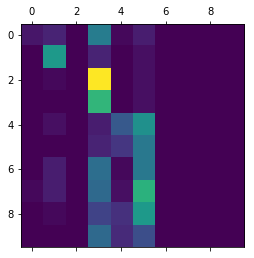

In [50]:
predictions = decisiontree.predict(testData)
testCM = confusion_matrix(y_pred=predictions,y_true=testY)
print(testCM)
plt.matshow(testCM);

# 5- Other method

C:\Users\almal\Anaconda3\lib\site-packages\skimage\segmentation\_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
C:\Users\almal\Anaconda3\lib\site-packages\skimage\segmentation\_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


<function matplotlib.pyplot.show(*args, **kw)>

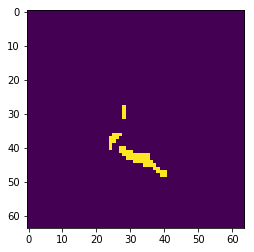

In [56]:
imageBis = X[1750]
thresh = threshold(imageBis)
#bw = closing(image>thresh,square(3)
cleared = clear_border(thresh)
plt.imshow(cleared)
plt.show

In [57]:
def labelRGB(image,clear):
    label_image = label(clear)
    image_label_overlay = label2rgb(label_image, image=image)
    return image_label_overlay

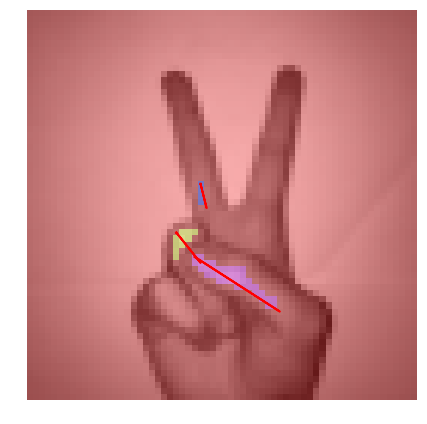

In [61]:
image_label_overlay = labelRGB(imageBis,cleared)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

label_image = label(cleared)
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 3:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        arrow = mpatches.FancyArrow(maxc, maxr, minc-maxc, minr-maxr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(arrow)

ax.set_axis_off()
plt.tight_layout()
plt.show()

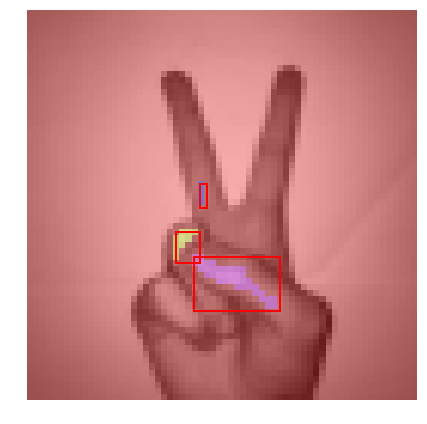

In [62]:
image_label_overlay = labelRGB(imageBis,cleared)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

label_image = label(cleared)
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 3:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()